In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from shapely.geometry import Polygon
import math
from haversine import haversine, Unit


In [4]:
df=pd.read_json('challenge_dataset.json')

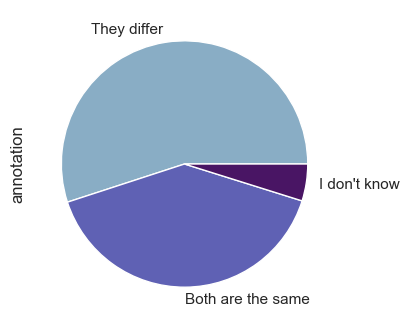

In [444]:
sns.set_theme(style='darkgrid')
sns.set_palette("twilight")
df['annotation'].value_counts().plot.pie(figsize=(4,4));

# DATA QUALITY

## Different annotations for the same journey:

I proceed to identify the registers where the annotation is different for the same journey:

In [439]:
df_different_annotations = df[df.groupby('journey_id')['annotation'].transform('nunique') > 1]

In [428]:
df_different_annotations

,journey_id,annotator,annotation,estimated_route,real_route,len_esti_route,len_real_route,area_m2,distance_real_r,distance_estimated_r,difference_distances
40,878553b4-5543-11ec-8511-9950cc15bf2f,1,I don't know,"[[4.74041, -74.06221], [4.74046, -74.06242], [...","[[4.740529, -74.062714], [4.74052, -74.062713]...",269,226,0.033052,7.102657,7.205445,-0.102788
41,878553b4-5543-11ec-8511-9950cc15bf2f,2,Both are the same,"[[4.74041, -74.06221], [4.74046, -74.06242], [...","[[4.740529, -74.062714], [4.74052, -74.062713]...",269,226,0.033052,7.102657,7.205445,-0.102788
70,2c013625-575b-11ec-8c14-d9c690d44ede,7,Both are the same,"[[-33.58247, -70.6656], [-33.58263, -70.66485]...","[[-33.582379, -70.665998], [-33.582379, -70.66...",525,483,4.606501,22.257495,22.716509,-0.459014
71,2c013625-575b-11ec-8c14-d9c690d44ede,5,I don't know,"[[-33.58247, -70.6656], [-33.58263, -70.66485]...","[[-33.582379, -70.665998], [-33.582379, -70.66...",525,483,4.606501,22.257495,22.716509,-0.459014
78,4cc903e4-5a6e-11ec-b347-e1e81d9998ac,2,They differ,"[[37.38101, -5.99355], [37.38104, -5.99367], [...","[[37.381013, -5.995019], [37.380967, -5.994986...",85,124,0.025773,2.914007,2.109641,0.804367
...,...,...,...,...,...,...,...,...,...,...,...
2638,c71c5880-54a6-11ec-87af-c565ea9421d1,3,Both are the same,"[[40.421, -3.69817], [40.42076, -3.69825], [40...","[[40.42121, -3.698092], [40.421174, -3.698107]...",202,136,0.002431,3.741188,3.414732,0.326455
2748,aa29f796-5b49-11ec-8b1f-0b356e20177a,2,They differ,"[[40.47382, -3.7051], [40.4738, -3.7051], [40....","[[40.473942, -3.705184], [40.473942, -3.705184...",669,108,0.992708,6.971135,7.517543,-0.546409
2749,aa29f796-5b49-11ec-8b1f-0b356e20177a,2,I don't know,"[[40.47382, -3.7051], [40.4738, -3.7051], [40....","[[40.473942, -3.705184], [40.473942, -3.705184...",669,108,0.992708,6.971135,7.517543,-0.546409
2783,c72b5d8c-5715-11ec-a4b8-d123064b4d18,6,They differ,"[[-12.11695, -77.01305], [-12.11699, -77.01305...","[[-12.116924, -77.013106], [-12.116924, -77.01...",470,354,0.254075,12.518621,12.424396,0.094224


I dentify how many couples, trios and quartets are for the same journey id.

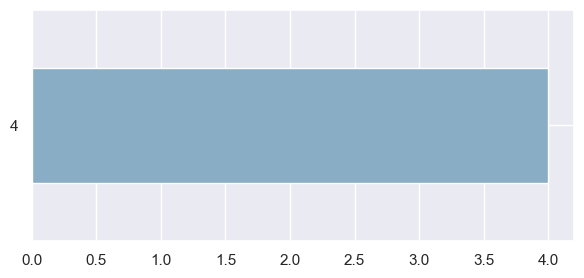

In [440]:
df_different_annotations.groupby('journey_id')['journey_id']\
.transform('count')\
.value_counts().plot.barh(figsize=(7,3))
sns.set_palette("twilight")

So there are:

- 182 registers that are couples
- 30 that are trios
- 4 that are quartets

We need to unify all these to have the same target info for each journey, in order not to have noise data in our training dataset.

I create the variable repetitions, that will be eliminate it once we solve this problem.

In [441]:
df_different_annotations['repetitions']=df_different_annotations.\
                                        groupby('journey_id')['journey_id'].\
                                            transform('count')

C:\Users\110927\AppData\Local\Temp\ipykernel_18592\119517437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_different_annotations['repetitions']=df_different_annotations.\


### Different annotation: Couples

In [437]:
df_different_annotations[df_different_annotations['repetitions']==2]['annotation'].value_counts()

I don't know         57
They differ          38
Both are the same    19
Name: annotation, dtype: int64

So there are 182 registers that are journey_id couples. 

Let's give credit to the annotators that have said something else from 'I don't know'. And eliminate those ones where annotators contradict eachother.

So I will eliminate: 182-(57*2)=68 registers. They are the 2.2% (68/3027) of the total. For this demo is fine. Even though, let's remember they are couples, so the real percentage is 1.1%

And I will change the value of annotation in 57 registers, to eliminate the value 'I don't know'.

With these changes we are done for this part.

In [ ]:
df_diff_2= df_different_annotations[df_different_annotations['repetitions'] == 2]

In [352]:
df_to_delete=df_diff_2[~df_diff_2['journey_id'].isin(
    df_diff_2[df_diff_2['annotation'] == "I don't know"]['journey_id'])]

In [433]:
df.drop(df_diff_2[df_diff_2['annotation']=="I don't know"].index, inplace=True)

In [443]:
df['annotation'].value_counts()

They differ          1580
Both are the same    1153
I don't know          139
Name: annotation, dtype: int64

In [234]:
df_to_delete.iloc[2:4]

,journey_id,annotator,annotation,estimated_route,real_route,repettions,repetitions
51,496b4bfd-5b07-11ec-9ab6-33834486a386,2,Both are the same,"[[4.6664200000000005, -74.07931], [4.66641, -7...","[[4.666263, -74.079433], [4.666263, -74.079434...",2,2
52,496b4bfd-5b07-11ec-9ab6-33834486a386,2,They differ,"[[4.6664200000000005, -74.07931], [4.66641, -7...","[[4.666263, -74.079433], [4.666263, -74.079434...",2,2


Let's draw a map to see how the differences are.

I am gonna use folium for this purpouse. 

I selected one route I think is very explanatory.

In [393]:
def create_map(index, zoom):    
    journey=df.loc[index]

    map_center=journey['estimated_route'][round(len(journey['estimated_route'])/2)]
    journey_map=folium.Map(location=map_center, zoom_start=zoom)
    journey_estimated=journey['estimated_route']
    journey_real=journey['real_route']

    folium.PolyLine(journey_estimated, color='blue').add_to(journey_map)
    folium.PolyLine(journey_real, color='red').add_to(journey_map)

    return journey_map

In [481]:
create_map(65, 14)

They are very similar. In my opinion this is not the same route. But for now with the resources and time available, I decide to keep with our previous decision of eliminating these registers.

Also, we do not know the instructions the annotators received. We would have to ask the business team encharge of this topic to understand how the annotations were made.

### Different annotation: Trios and quartets

In [354]:
df_diff_3= df_different_annotations[df_different_annotations['repetitions'] == 3]
df_diff_4= df_different_annotations[df_different_annotations['repetitions'] == 4]

For the quartet I am going to set all of them as 'Both are the same'

In [355]:
df_diff_4

,journey_id,annotator,annotation,estimated_route,real_route,repettions,repetitions
1192,b3df0630-54a3-11ec-b344-ab8c7bd1aa5c,7,Both are the same,"[[-12.12779, -77.0133], [-12.12772, -77.01375]...","[[-12.127787, -77.013175], [-12.127778, -77.01...",4,4
1193,b3df0630-54a3-11ec-b344-ab8c7bd1aa5c,6,They differ,"[[-12.12779, -77.0133], [-12.12772, -77.01375]...","[[-12.127787, -77.013175], [-12.127778, -77.01...",4,4
1194,b3df0630-54a3-11ec-b344-ab8c7bd1aa5c,4,Both are the same,"[[-12.12779, -77.0133], [-12.12772, -77.01375]...","[[-12.127787, -77.013175], [-12.127778, -77.01...",4,4
1195,b3df0630-54a3-11ec-b344-ab8c7bd1aa5c,2,Both are the same,"[[-12.12779, -77.0133], [-12.12772, -77.01375]...","[[-12.127787, -77.013175], [-12.127778, -77.01...",4,4


In [363]:
df.iloc[df_diff_4.index]['annotation']='Both are the same'

C:\Users\110927\AppData\Local\Temp\ipykernel_18592\2187511729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[df_diff_4.index]['annotation']='Both are the same'


For the trios, I am going to get a list and see how they are distributed, unstacking them, and showing them in terms of the annotation received.

In [240]:
df_diff_3.groupby('journey_id')['annotation']\
.value_counts().unstack(fill_value=0)\
.sort_values(by='Both are the same')

annotation,Both are the same,I don't know,They differ
journey_id,,,
96320f6c-5a46-11ec-a66a-8d299b2f33d0,0,1,2
bfab656a-5c07-11ec-9739-f17d0371a7fa,0,1,2
d1d39664-5436-11ec-8369-e9c18ab4dae7,0,1,2
e1f245d0-5711-11ec-875a-2f4d7245bfe0,0,2,1
24e2a579-5ae0-11ec-8632-7da3475d8ea0,1,1,1
34c8ba45-5aa0-11ec-b771-1768151b4934,1,1,1
4f8359a7-5749-11ec-abf8-9b82da5f65c0,1,0,2
e36bf96c-59f0-11ec-acdb-093843ba27e7,1,1,1
a629ccf4-56fb-11ec-9f3b-97958b4887d3,2,1,0


As you can see, there is no relation between them. So, in order not to lose much time with this, I am going to get rid of all of them. In a real case this should not be do it like this, if we want to reach a great performance from the model. But in my case, as I said, I have limited time, and I think is better to invest it in explaining the reasons why I do the actions I take. 

In summary they will be 68 from the previous one, and 30 from this one, 98 in total.

In [357]:
df_to_delete = pd.concat([df_to_delete, df_diff_3], axis=0)

In [366]:
df=df.drop(df_to_delete.index)

In [368]:
df.shape

(2929, 8)

I check the change has been made succesfully:

In [369]:
3027-98

2929

## What we do with the "I don't know"s?

In [450]:
df[df['annotation']=="I don't know"].shape[0]/df.shape[0]*100

4.83983286908078

My decision here is going to be the same. I will eliminate them, in order to save time.

I could impute them using the variable "area_m2", that I will create later on. But I don't think is a great solution eather: I do not want to leave that much weight on that variable. If I leave more wieght in the best predictor variable, it might overfit in the future.

In [451]:
df = df[df['annotation'] != "I don't know"]

## Creating new variables:

I am going to use scikitlearn, so I need that the routes are shown in numeric values. I have to decompose the lists of locations into new variables.

### Testing coordinates as variables

Let's check how many values each list has. In order to check if we could agregate them as new variables. It looks like it won't be possible (there will be a reason why they are compressed into one variable), but let's check it.

In [269]:
df['len_esti_route'] = df['estimated_route'].apply(len)
df['len_real_route'] = df['real_route'].apply(len)

In [276]:
round(df.drop(columns='annotator').describe().T)

,count,mean,std,min,25%,50%,75%,max
len_esti_route,3027.0,332.0,265.0,8.0,135.0,255.0,469.0,1886.0
len_real_route,3027.0,241.0,160.0,5.0,129.0,199.0,306.0,1270.0


The list of values is enormous, reaching 200 at the median. And let's not forget that would have to be summed up, and multiply by two, because each value has a longitude value and a latitude value. So it will be almost 800 variables for just the median. And that amount of variables for 3000 records it's simply not viable.

We could interpole the values, to reduce the number of coordinates but, anyway, I think this is not the way. It is good to check all the posibilities, to learn though.

### Calculating the area between the real and the estimated route:

In [476]:
def degrees_to_kms(area_in_radians):
    earth_radius=6371
    return area_in_radians*(math.pi /180) ** 2 * earth_radius ** 2
def calculate_area(row):
    route1 = row['estimated_route']
    route2 = row['real_route'][::-1]
    polygon_coords = route1 + route2
    
    polygon = Polygon(polygon_coords)
    area_in_radians = polygon.area
    area_in_meters = degrees_to_kms(area_in_radians)
    return area_in_meters

df['area_m2'] = df.apply(calculate_area, axis=1)

C:\Users\110927\AppData\Local\Temp\ipykernel_18592\2312632967.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_m2'] = df.apply(calculate_area, axis=1)


In [453]:
df.groupby('annotation')['area_m2'].describe().T

annotation,Both are the same,They differ
count,1153.000000,1580.000000
mean,0.112978,6.437005
std,0.304600,16.755088
min,0.000023,0.000584
25%,0.006005,0.417019
50%,0.019623,1.602559
75%,0.079556,5.681513
max,4.606501,398.380583


Checking the metrics for the area, I see there are some values that exceed the common sense. Like the area of almost 400km2. I'm gonna sketch a map to see how that can be possible, or insted we are talking of an outlier here.

In [482]:
create_map(2567, 10)

The blue line is the estimated one. Unless the user scheduled a stop and then did not want to stop there, or there was constructions obstacles... I cannot see this other way than an error, so I am gonna sketch more maps with an important area between the routes.

In [477]:
df[df['area_m2']>100]

,journey_id,annotator,annotation,estimated_route,real_route,len_esti_route,len_real_route,area_m2,distance_real_r,distance_estimated_r,difference_distances
627,2f4da6e5-548e-11ec-9618-3515f90c81a4,1,They differ,"[[-34.61754, -58.40545], [-34.61899, -58.40509...","[[-34.61751, -58.405644], [-34.617511, -58.405...",1137,393,136.598955,23.107590,29.572307,-6.464717
628,2f4da6e5-548e-11ec-9618-3515f90c81a4,2,They differ,"[[-34.61754, -58.40545], [-34.61899, -58.40509...","[[-34.61751, -58.405644], [-34.617511, -58.405...",1137,393,136.598955,23.107590,29.572307,-6.464717
1876,e97f7ebc-5cb7-11ec-b0b6-95f4bdef0fb6,1,They differ,"[[37.2819, -5.91662], [37.28197, -5.91653], [3...","[[37.281886, -5.916649], [37.28189, -5.916641]...",1224,311,104.474884,30.058771,21.331202,8.727569
1877,e97f7ebc-5cb7-11ec-b0b6-95f4bdef0fb6,7,They differ,"[[37.2819, -5.91662], [37.28197, -5.91653], [3...","[[37.281886, -5.916649], [37.28189, -5.916641]...",1224,311,104.474884,30.058771,21.331202,8.727569
1982,6812a1b0-56ba-11ec-9c51-459a9ebea546,4,They differ,"[[-33.41537, -70.5839], [-33.41517, -70.584], ...","[[-33.415238, -70.58388], [-33.415238, -70.583...",685,330,117.167780,24.154638,24.030253,0.124385
2091,f93435cc-5370-11ec-8d49-db7acdf0167f,1,They differ,"[[40.54509, -3.65611], [40.5451, -3.65661], [4...","[[40.545092, -3.655442], [40.545092, -3.655442...",1179,391,106.334912,27.603271,22.510106,5.093165
2567,d90bdb26-587d-11ec-8cf5-4d1f2c6278c1,7,They differ,"[[-34.90884, -58.36936], [-34.90898, -58.36926...","[[-34.909333, -58.369866], [-34.90931899999999...",1493,816,398.380583,35.461101,57.001449,-21.540348


In [479]:
create_map(627, 10)

In [480]:
create_map(1876, 10)

These two look more normal to me.

It is curious two of them are from Buenos Aires, it could be a thing in here, if we had more time, we could investigatigate deeply on it.

I think it is good to check these not so common values, and visualize them.

### Calculating the difference between the distances of each route:

In [407]:
def calculate_distance(route):
    total_distance = 0
    for i in range(1, len(route)):
        total_distance += haversine(route[i-1], route[i], unit=Unit.KILOMETERS)
    return total_distance

df['distance_real_r'] = df['real_route'].apply(calculate_distance)
df['distance_estimated_r'] = df['estimated_route'].apply(calculate_distance)

In [410]:
df['difference_distances']=df['distance_real_r']-df['distance_estimated_r']

In [455]:
df.groupby('annotation')['difference_distances'].describe().T

annotation,Both are the same,They differ
count,1153.000000,1580.000000
mean,0.006248,-0.069761
std,0.515208,2.034905
min,-3.417226,-21.540348
25%,-0.103970,-0.562497
50%,-0.021384,-0.023331
75%,0.080962,0.525304
max,10.534459,15.949706


# Hago una primera prueba predictiva

In [486]:
df['annotation'].value_counts()

They differ          1580
Both are the same    1153
Name: annotation, dtype: int64

Im going to call the "Both are the same" as 1's, and the "They differ" as 0's.

In [489]:
df['target'] = np.where(df['annotation'] == 'Both are the same', 1, 0)

C:\Users\110927\AppData\Local\Temp\ipykernel_18592\3468967020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['annotation'] == 'Both are the same', 1, 0)


I'm gonna keep the ids in a separate dataframe:

In [491]:
journey_ids=df['journey_id']

In [492]:
df.columns

Index(['journey_id', 'annotator', 'annotation', 'estimated_route',
       'real_route', 'len_esti_route', 'len_real_route', 'area_m2',
       'distance_real_r', 'distance_estimated_r', 'difference_distances',
       'target'],
      dtype='object')

In [493]:
x=df.drop(columns=['journey_id', 'annotation','estimated_route','real_route','target'])

In [494]:
y=df['target']

I separate the test dataset, it will be 20%, because our training data is already limited. Normally I would take 30% or so.

In [499]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2)

In [500]:
from sklearn.model_selection import KFold
kf= KFold(n_splits=5)

In [506]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
log_reg= LogisticRegression()
met_cv_log_reg=cross_val_score(estimator=log_reg, X=train_x, y=train_y, cv=kf, scoring='roc_auc')
print(met_cv.mean())

0.9636288647674975


C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [508]:
log_reg.fit(train_x, train_y)

C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

I am going to use '.predict()' for simplicity, but for some grey cases, I would do 'predict_proba()' and check how is perfoming.

In [509]:
pred_log_reg=log_reg.predict(val_x)

In [532]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(val_y, pred_log_reg)

0.9061825278192992

## Testing performance of Random Forest

In [544]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
pipe = Pipeline([('algorithm', RandomForestClassifier())])
grid = [{'algorithm': [RandomForestClassifier()],
        'algorithm__max_depth': [8, 9, 10],
        'algorithm__n_estimators': [100, 200, 300],
        'algorithm__min_samples_split': [2, 5, 10],
        'algorithm__min_samples_leaf': [1, 2, 4],
        'algorithm__max_features': ['auto', 'sqrt', 'log2'],
        'algorithm__bootstrap': [True, False]},
        
        {'algorithm': [lgb.LGBMClassifier()],
        'algorithm__num_leaves': [31, 50, 100],
        'algorithm__max_depth': [-1, 10, 20],
        'algorithm__learning_rate': [0.01, 0.1, 0.2],
        'algorithm__n_estimators': [100, 200, 300],
        'algorithm__min_child_samples': [20, 30, 50],
        'algorithm__subsample': [0.8, 0.9, 1.0],
        'algorithm__colsample_bytree': [0.8, 0.9, 1.0]}]

random_search = RandomizedSearchCV(estimator=pipe,param_distributions=grid,n_iter=100,  
                                   cv=5,scoring='roc_auc',n_jobs=-1,verbose=3)
random_search.fit(train_x, train_y)
best_model = random_search.best_estimator_
print('Best combination:', random_search.best_params_)
best_algorithm = best_model.named_steps['algorithm']
print('Best model:', best_algorithm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best combination: {'algorithm__subsample': 1.0, 'algorithm__num_leaves': 100, 'algorithm__n_estimators': 100, 'algorithm__min_child_samples': 50, 'algorithm__max_depth': -1, 'algorithm__learning_rate': 0.1, 'algorithm__colsample_bytree': 0.8, 'algorithm': LGBMClassifier(colsample_bytree=0.8, min_child_samples=50, num_leaves=100)}
Best model: LGBMClassifier(colsample_bytree=0.8, min_child_samples=50, num_leaves=100)


In [545]:
best_model=random_search.fit(train_x, train_y)
print('Best combination:', random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best combination: {'algorithm__subsample': 0.9, 'algorithm__num_leaves': 50, 'algorithm__n_estimators': 100, 'algorithm__min_child_samples': 50, 'algorithm__max_depth': 20, 'algorithm__learning_rate': 0.1, 'algorithm__colsample_bytree': 0.8, 'algorithm': LGBMClassifier(colsample_bytree=0.8, max_depth=20, min_child_samples=50,
               num_leaves=50, subsample=0.9)}


In [546]:
pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm__subsample,param_algorithm__num_leaves,param_algorithm__n_estimators,param_algorithm__min_child_samples,param_algorithm__max_depth,param_algorithm__learning_rate,...,param_algorithm__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
96,0.163936,0.007378,0.012956,0.003987,0.9,50,100,50,20,0.1,...,NaN,"{'algorithm__subsample': 0.9, 'algorithm__num_...",0.987114,0.987234,0.991068,0.991282,0.981515,0.987643,0.003549,1
75,0.121878,0.005205,0.011163,0.002128,0.9,31,100,50,10,0.1,...,NaN,"{'algorithm__subsample': 0.9, 'algorithm__num_...",0.986751,0.986656,0.991475,0.991925,0.981108,0.987583,0.003936,2
17,0.097726,0.003573,0.007974,0.000891,0.9,31,100,50,-1,0.1,...,NaN,"{'algorithm__subsample': 0.9, 'algorithm__num_...",0.986922,0.986613,0.991389,0.991518,0.981343,0.987557,0.003749,3
58,0.188823,0.011119,0.011981,0.000317,0.9,50,100,30,10,0.1,...,NaN,"{'algorithm__subsample': 0.9, 'algorithm__num_...",0.986367,0.987727,0.991175,0.990725,0.981643,0.987527,0.003451,4
74,0.153985,0.008960,0.010365,0.000488,0.9,31,100,30,20,0.2,...,NaN,"{'algorithm__subsample': 0.9, 'algorithm__num_...",0.985194,0.986077,0.992503,0.990918,0.982693,0.987477,0.003665,5


In [530]:
pred_rf=best_model.best_estimator_.predict(val_x)

In [531]:
roc_auc_score(val_y, pred_rf)

0.9371920500470575

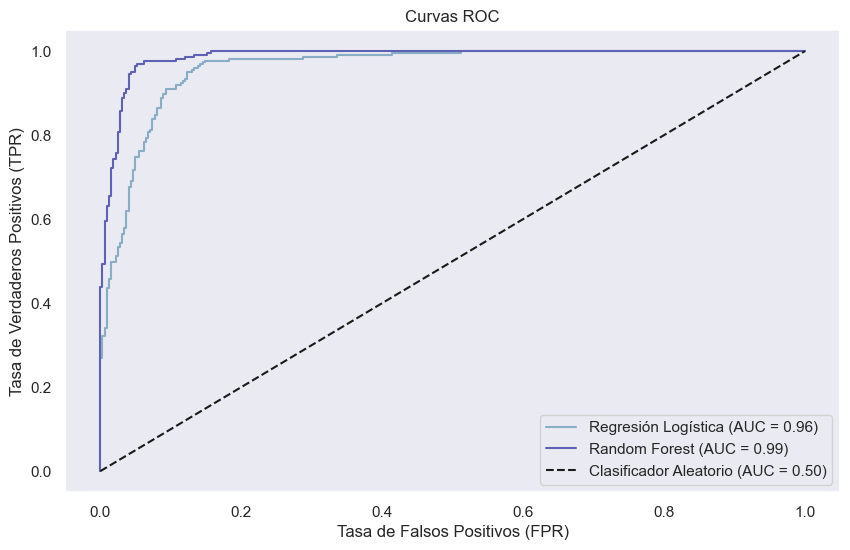

In [548]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_log_reg = log_reg.predict_proba(val_x)[:, 1]
y_proba_best_model = best_model.predict_proba(val_x)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(val_y, y_proba_log_reg)
fpr_best_model, tpr_best_model, _ = roc_curve(val_y, y_proba_best_model)
auc_log_reg = roc_auc_score(val_y, y_proba_log_reg)
auc_best_model = roc_auc_score(val_y, y_proba_best_model)
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Regresión Logística (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_best_model, tpr_best_model, label=f'Random Forest (AUC = {auc_best_model:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc='best')
plt.grid()

In [549]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred_log_reg = log_reg.predict(val_x)
y_pred_best_model = best_model.predict(val_x)

# Calcular métricas para la regresión logística
precision_log_reg = precision_score(val_y, y_pred_log_reg)
recall_log_reg = recall_score(val_y, y_pred_log_reg)
f1_log_reg = f1_score(val_y, y_pred_log_reg)

# Calcular métricas para el mejor modelo (Random Forest)
precision_best_model = precision_score(val_y, y_pred_best_model)
recall_best_model = recall_score(val_y, y_pred_best_model)
f1_best_model = f1_score(val_y, y_pred_best_model)

metrics_df = pd.DataFrame({
    'Model': ['Regresión Logística', 'Random Forest'],
    'Precision': [precision_log_reg, precision_best_model],
    'Recall': [recall_log_reg, recall_best_model],
    'F1-score': [f1_log_reg, f1_best_model]
})
round(metrics_df,2)

,Model,Precision,Recall,F1-score
0,Regresión Logística,0.84,0.93,0.89
1,Random Forest,0.93,0.96,0.94


### Logistic Regression
Precision: 0.84: Of all the positive predictions made by the model, 84% were correct. This means that the model has a good ability to avoid false positives.

Recall: 0.93: Of all the actual positive instances, the model correctly identified 93%. This indicates that the model is very good at detecting most of the positive instances (low number of false negatives).

F1-score: 0.89: The F1-score is the harmonic mean of precision and recall. A value of 0.89 suggests a good balance between precision and recall.

### Random Forest
Precision: 0.93: 93% of the positive predictions of the model were correct. This indicates a high ability to avoid false positives.

Recall: 0.92: The model correctly identified 92% of the true positive instances. This shows that the model is very good at detecting positive instances.

F1-score: 0.93: An F1-score of 0.93 indicates an excellent balance between precision and recall, slightly better than the logistic regression model.


### Comparison

Accuracy: Random Forest has a slightly higher accuracy (0.93) compared to logistic regression (0.84). This means that Random Forest is better at avoiding false positives.

Recall: Logistic regression has a slightly higher recall (0.93) compared to Random Forest (0.92). This means that logistic regression is slightly better at detecting all positive instances.

F1-score: The Random Forest has a slightly higher F1-score (0.93) compared to the logistic regression (0.89). This suggests that Random Forest has a better overall balance between precision and recall.

In summary, both models perform very well, but the Random Forest seems to have a slight advantage in terms of precision and F1-score, indicating a better overall balance between avoiding false positives and detecting positive instances.
